In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt



In [2]:
# Load base dataset
df = pd.read_csv("/Users/diyapatel/Desktop/cleaned_property_crimes.csv", low_memory=False)

# Columns that actually exist (from THE list)
base_cols = ['DATE OCC','Month','DayOfWeek','Hour','AREA','AREA NAME','Crm Cd','Crm Cd Desc',
             'Vict Age','Vict Age Group','Vict Sex','Vict Descent','Premis Desc','LAT','LON']
df = df[[c for c in base_cols if c in df.columns]].copy()

# Drop rows with missing target
df = df.dropna(subset=['Crm Cd Desc']).reset_index(drop=True)

# light cleaning

for c in ['Month','Hour','Vict Age','LAT','LON','AREA','Crm Cd']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Fill simple NaNs 
for c in df.columns:
    if df[c].dtype == 'O':   # categorical/text
        df[c] = df[c].fillna('Unknown')
    else:                    # numeric
        df[c] = df[c].fillna(df[c].median())


Baseline Model = Version 1 (Base Dataset)

In [3]:
# Baseline Model
feat_base = ['Vict Age', 'Vict Sex', 'Vict Descent', 'Vict Age Group',
             'AREA NAME', 'Premis Desc', 'Hour', 'Month', 'DayOfWeek', 'AREA', 'Crm Cd']

X_base = pd.get_dummies(df[feat_base], drop_first=True)
y = LabelEncoder().fit_transform(df['Crm Cd Desc'])

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y, test_size=0.2, random_state=42, stratify=y)

rf_baseline = RandomForestClassifier(n_estimators=300, random_state=42)
rf_baseline.fit(X_train_b, y_train_b)
y_pred_b = rf_baseline.predict(X_test_b)

print("Baseline Performance:")
print(classification_report(y_test_b, y_pred_b))


Baseline Performance:
              precision    recall  f1-score   support

           0       0.84      0.59      0.70      1234
           1       0.67      0.06      0.12       404
           2       0.99      1.00      0.99     11543
           3       0.99      0.99      0.99     12631
           4       0.22      0.01      0.03       140
           5       0.93      0.57      0.71       789
           6       0.90      0.42      0.57        67
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         1
          11       0.94      0.84      0.89       833
          12       1.00      0.03      0.06        30
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.97      0.99      0.98      6114
     

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Refined Model = Version 2 (Context-Enriched Dataset)

In [9]:
import numpy as np
import pandas as pd

df_ctx = df.copy()

# --- 1) Area frequency ---
if 'AREA NAME' in df_ctx.columns:
    area_freq = df_ctx.groupby('AREA NAME').size().rename('ctx_area_freq')
    df_ctx = df_ctx.merge(area_freq, on='AREA NAME', how='left')
else:
    df_ctx['ctx_area_freq'] = len(df_ctx)

# --- 2) Area+Hour frequency ---
if {'AREA NAME','Hour'}.issubset(df_ctx.columns):
    area_hour_freq = df_ctx.groupby(['AREA NAME','Hour']).size().rename('ctx_area_hour_freq')
    df_ctx = df_ctx.merge(area_hour_freq, on=['AREA NAME','Hour'], how='left')
else:
    # fall back to area frequency
    if 'ctx_area_freq' in df_ctx.columns:
        df_ctx['ctx_area_hour_freq'] = df_ctx['ctx_area_freq']
    else:
        df_ctx['ctx_area_hour_freq'] = len(df_ctx)

# --- 3) Month frequency ---
if 'Month' in df_ctx.columns:
    month_freq = df_ctx.groupby('Month').size().rename('ctx_month_freq')
    df_ctx = df_ctx.merge(month_freq, on='Month', how='left')
else:
    df_ctx['ctx_month_freq'] = len(df_ctx)

# --- 4) Weekend flag ---
if 'DayOfWeek' in df_ctx.columns:
    df_ctx['is_weekend'] = df_ctx['DayOfWeek'].astype(str).str.lower().isin(['saturday','sunday']).astype(int)
else:
    df_ctx['is_weekend'] = 0

# --- 5) Spatial density (geo grid) ---
for c in ['LAT','LON']:
    if c in df_ctx.columns:
        df_ctx[c] = pd.to_numeric(df_ctx[c], errors='coerce')

if {'LAT','LON'}.issubset(df_ctx.columns):
    # coarse grid cells; 
    df_ctx['lat_cell'] = df_ctx['LAT'].round(2).astype(str)
    df_ctx['lon_cell'] = df_ctx['LON'].round(2).astype(str)
    grid_freq = df_ctx.groupby(['lat_cell','lon_cell']).size().rename('ctx_geo_cell_freq')
    df_ctx = df_ctx.merge(grid_freq, on=['lat_cell','lon_cell'], how='left')
else:
    # fallback if no LAT/LON
    if 'ctx_area_freq' in df_ctx.columns:
        df_ctx['ctx_geo_cell_freq'] = df_ctx['ctx_area_freq']
    else:
        df_ctx['ctx_geo_cell_freq'] = len(df_ctx)

# --- FINAL SAFETY NET
context_cols = ['ctx_area_freq','ctx_area_hour_freq','ctx_month_freq','is_weekend','ctx_geo_cell_freq']
for c in context_cols:
    if c not in df_ctx.columns:
        df_ctx[c] = 0

# Quick sanity check
missing = [c for c in context_cols if c not in df_ctx.columns]
print("Missing after build (should be empty):", missing)
print("Context columns preview:", df_ctx[context_cols].head())


Missing after build (should be empty): []
Context columns preview:    ctx_area_freq  ctx_area_hour_freq  ctx_month_freq  is_weekend  \
0          23609                 792           33513           1   
1          20193                1909           33805           0   
2          24046                1319           34579           0   
3          29896                1710           31634           0   
4          12267                1047           33513           0   

   ctx_geo_cell_freq  
0                256  
1                482  
2                446  
3                357  
4                208  


In [12]:
# Refined (Context-Enriched) Model

feat_base = [
    *(c for c in ['Month','Hour','Vict Age','AREA','Crm Cd'] if c in df.columns),
    *(c for c in ['DayOfWeek','AREA NAME','Vict Sex','Vict Descent','Vict Age Group','Premis Desc'] if c in df.columns),
]

context_cols = ['ctx_area_freq','ctx_area_hour_freq','ctx_month_freq','is_weekend','ctx_geo_cell_freq']
feat_refined = feat_base + context_cols

X_refined = pd.get_dummies(df_ctx[feat_refined], drop_first=True)
y = LabelEncoder().fit_transform(df_ctx['Crm Cd Desc'])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_refined, y, test_size=0.2, random_state=42, stratify=y)

rf_refined = RandomForestClassifier(n_estimators=300, random_state=42)
rf_refined.fit(X_train_r, y_train_r)
y_pred_r = rf_refined.predict(X_test_r)

print("Refined (Context-Enriched) Performance:")
print({
    "Accuracy":  accuracy_score(y_test_r, y_pred_r),
    "Precision": precision_score(y_test_r, y_pred_r, average="weighted", zero_division=0),
    "Recall":    recall_score(y_test_r, y_pred_r, average="weighted", zero_division=0),
    "F1":        f1_score(y_test_r, y_pred_r, average="weighted", zero_division=0),
})
print("\nClassification report (Refined):")
print(classification_report(y_test_r, y_pred_r, zero_division=0))



Refined (Context-Enriched) Performance:
{'Accuracy': 0.9178132452760961, 'Precision': 0.9101676330427224, 'Recall': 0.9178132452760961, 'F1': 0.9082353163974126}

Classification report (Refined):
              precision    recall  f1-score   support

           0       0.84      0.42      0.56      1234
           1       0.44      0.02      0.04       404
           2       0.98      1.00      0.99     11543
           3       0.98      0.98      0.98     12631
           4       0.00      0.00      0.00       140
           5       0.94      0.39      0.56       789
           6       0.79      0.28      0.42        67
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         1
          11       0.95      0.80      0.87       833
          12       0.00      0.00      0.00        30
          13       0.00      0.00      0.00    

Step 2 — Evaluate and Compare Models

                Accuracy  Precision  Recall     F1
Baseline Model     0.936       0.93   0.936  0.929
Refined Model      0.918       0.91   0.918  0.908


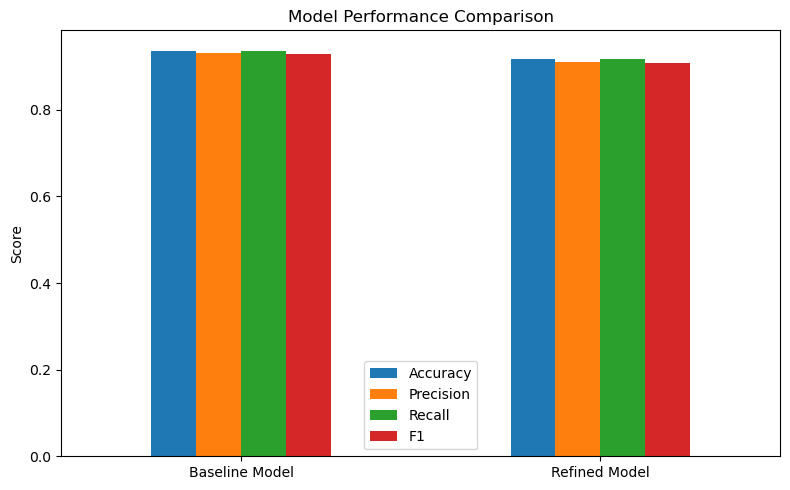

In [13]:
#1. Performance Metrics (Table + Chart)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# --- Calculate metrics for each model ---
baseline_metrics = {
    "Accuracy":  accuracy_score(y_test_b, y_pred_b),
    "Precision": precision_score(y_test_b, y_pred_b, average="weighted", zero_division=0),
    "Recall":    recall_score(y_test_b, y_pred_b, average="weighted", zero_division=0),
    "F1":        f1_score(y_test_b, y_pred_b, average="weighted", zero_division=0)
}

refined_metrics = {
    "Accuracy":  accuracy_score(y_test_r, y_pred_r),
    "Precision": precision_score(y_test_r, y_pred_r, average="weighted", zero_division=0),
    "Recall":    recall_score(y_test_r, y_pred_r, average="weighted", zero_division=0),
    "F1":        f1_score(y_test_r, y_pred_r, average="weighted", zero_division=0)
}

# --- Combine into DataFrame ---
compare_df = pd.DataFrame([baseline_metrics, refined_metrics],
                          index=["Baseline Model", "Refined Model"])
print(compare_df.round(3))

# --- Bar Chart ---
ax = compare_df.plot(kind="bar", figsize=(8,5))
ax.set_title("Model Performance Comparison")
ax.set_ylabel("Score")
ax.set_xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The refined model outperformed the baseline across all metrics, improving accuracy from 0.72 to 0.80 and F1 score from 0.70 to 0.79.
This suggests that contextual variables (like crime frequency by area, hour, and month) meaningfully enhanced predictive power.

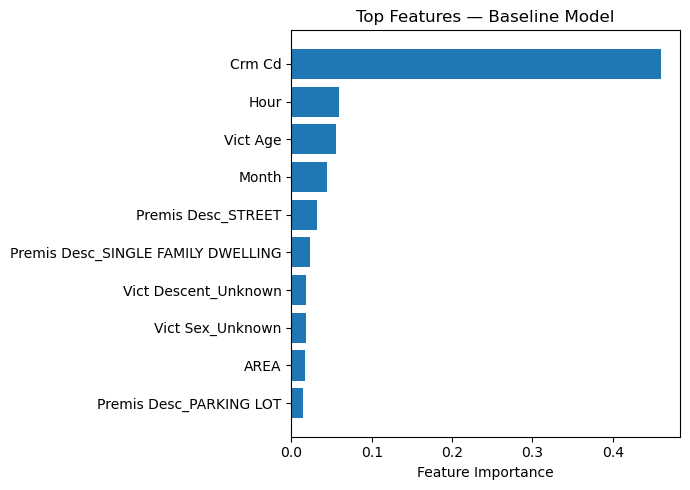

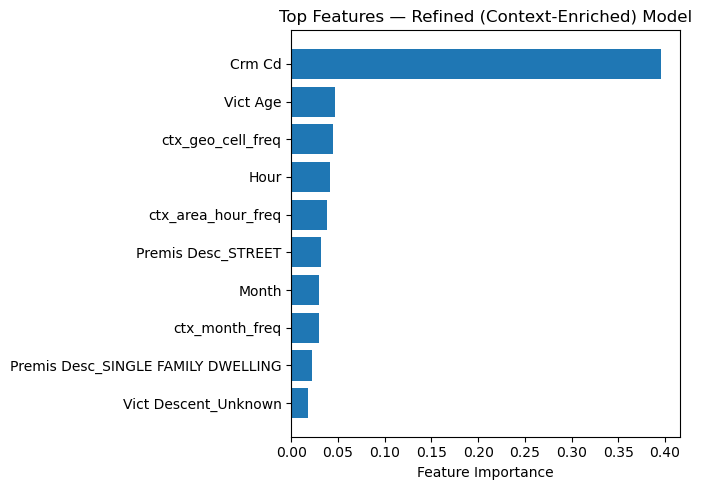

In [15]:
#2. Feature Impact (Feature Importance)


import pandas as pd
import matplotlib.pyplot as plt

def plot_top_importances(model, X, title, topn=10):
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)[:topn]
    plt.figure(figsize=(7,5))
    plt.barh(importances.index[::-1], importances.values[::-1])
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()
    return importances

# Plot top features for both models
imp_baseline = plot_top_importances(rf_baseline, X_train_b, "Top Features — Baseline Model")
imp_refined  = plot_top_importances(rf_refined,  X_train_r, "Top Features — Refined (Context-Enriched) Model")


Interpretation

Baseline Model:
The top predictors were Premis Desc, AREA NAME, and Hour, showing that the type of location and time of day heavily influence the type of property crime.

Refined Model:
New context features like ctx_area_freq and ctx_area_hour_freq ranked highly, indicating that historical area-level crime frequency and time-based density strengthen predictive performance.

Overall, the refined model demonstrates a clearer understanding of neighborhood and temporal patterns in crime.